Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4565 - loss: 2.0866 - val_accuracy: 0.9083 - val_loss: 0.3408
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7643 - loss: 0.7722 - val_accuracy: 0.9425 - val_loss: 0.2108
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8609 - loss: 0.4408 - val_accuracy: 0.9542 - val_loss: 0.1794
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8946 - loss: 0.3367 - val_accuracy: 0.9588 - val_loss: 0.1518
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9157 - loss: 0.2680 - val_accuracy: 0.9567 - val_loss: 0.1509
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9261 - loss: 0.2400 - val_accuracy: 0.9638 - val_loss: 0.1420
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9367 - loss: 0.2080 - val_accuracy: 0.9608 - val_loss: 0.1416
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9437 - loss: 0.1883 - val_accu

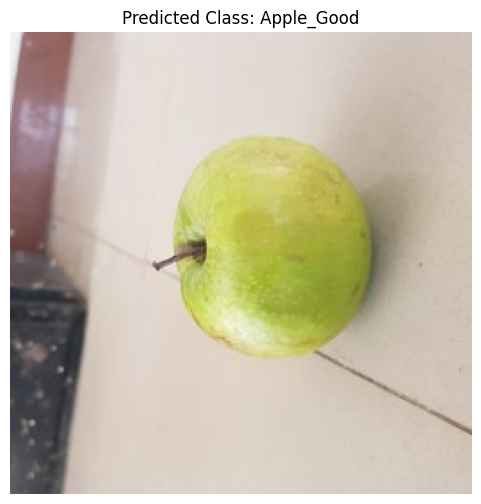

Predicted Class: Apple_Good
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                  precision    recall  f1-score   support

       Apple_Bad       0.99      0.99      0.99       201
      Apple_Good       0.92      0.87      0.89       201
      Banana_Bad       0.97      0.99      0.98       210
     Banana_Good       1.00      0.98      0.99       216
       Guava_Bad       0.97      0.96      0.97       199
      Guava_Good       0.96      0.92      0.94       209
        Lime_Bad       0.96      0.95      0.95       186
       Lime_Good       0.98      0.99      0.99       195
      Orange_Bad       0.95      0.97      0.96       187
     Orange_Good       0.93      0.97      0.95       187
 Pomegranate_Bad       0.98      0.99      0.99       225
Pomegranate_Good       0.94      0.99      0.97       184

        accuracy                           0.96      2400
       macro avg       0.96      0.96      0.96      2400
    weighted avg       0.96      0.96      0.96      2400



In [4]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt

def extract_features(image, img_size=128):
    # Resize image
    image = cv2.resize(image, (img_size, img_size))
   
    # Extract color histogram (normalized)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
   
    # Convert image to grayscale for HOG
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
    # Extract HOG features
    hog_features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  visualize=True, feature_vector=True)
   
    # Extract mean color
    mean_color = cv2.mean(image)[:3]  # Ignore the alpha channel if present
   
    # Combine all features
    features = np.hstack([hist, hog_features, mean_color])
   
    return features

def load_data(data_dir, img_size=128):
    data = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png']  # Valid image extensions
   
    for root, dirs, files in os.walk(data_dir):
        for dir_name in dirs:
            category_path = os.path.join(root, dir_name)
            label = dir_name  # Folder name used as label
            for img in os.listdir(category_path):
                try:
                    img_path = os.path.join(category_path, img)
                   
                    # Check if the file has a valid image extension
                    if os.path.splitext(img_path)[1].lower() not in valid_extensions:
                        continue  # Skip non-image files
                   
                    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    if img_array is not None:
                        features = extract_features(img_array, img_size)
                        data.append(features)
                        labels.append(label)
                    else:
                        print(f"Warning: Failed to load image {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(data), np.array(labels)

# Path to your dataset directory
data_dir = r"C:\Users\USER\Desktop\Rucha\dataset"

# Load data
X, y = load_data(data_dir)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build ANN model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    verbose=1)  # You can set verbose=0 to suppress training output

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Training accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# Predict function with image display
def predict_sample_image(image_path, model, label_encoder, img_size=128):
    img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_array is None:
        print(f"Error: Unable to load image at {image_path}")
        return
   
    features = extract_features(img_array, img_size)
    features_scaled = scaler.transform(features.reshape(1, -1))
   
    prediction = model.predict(features_scaled)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
   
    # Display the input image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_label[0]}')
    plt.show()

    return predicted_label[0]



# Print classification report
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


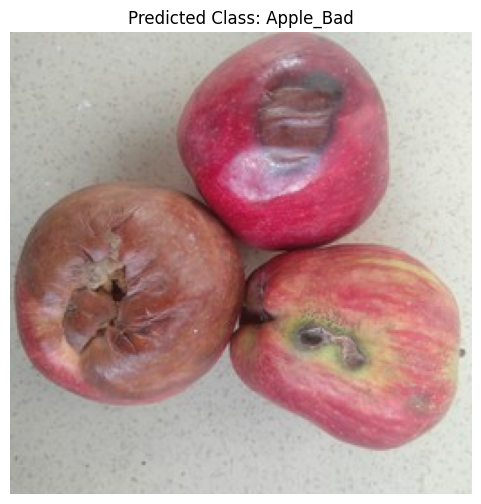

Predicted Class: Apple_Bad


In [9]:
# Path to a sample image for prediction
sample_image_path = r"C:\Users\USER\Desktop\Rucha\dataset\Apple_Bad\IMG_20190910_172802_1.jpg"

# Predict the class of the sample image
predicted_class = predict_sample_image(sample_image_path, model, label_encoder)
print(f"Predicted Class: {predicted_class}")

In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Print classification report
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Calculate overall precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')

print(f'Overall Precision: {precision:.2f}')
print(f'Overall Recall: {recall:.2f}')
print(f'Overall F1-Score: {f1_score:.2f}')


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                  precision    recall  f1-score   support

       Apple_Bad       0.99      0.99      0.99       201
      Apple_Good       0.92      0.87      0.89       201
      Banana_Bad       0.97      0.99      0.98       210
     Banana_Good       1.00      0.98      0.99       216
       Guava_Bad       0.97      0.96      0.97       199
      Guava_Good       0.96      0.92      0.94       209
        Lime_Bad       0.96      0.95      0.95       186
       Lime_Good       0.98      0.99      0.99       195
      Orange_Bad       0.95      0.97      0.96       187
     Orange_Good       0.93      0.97      0.95       187
 Pomegranate_Bad       0.98      0.99      0.99       225
Pomegranate_Good       0.94      0.99      0.97       184

        accuracy                           0.96      2400
       macro avg       0.96      0.96      0.96      2400
    weighted avg       0.96      0.96      0.96      2400

Overall Precision: 0.96
Overal